In [73]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image 
from skimage.color import rgb2gray
import scipy
from scipy import ndimage, misc
from scipy.ndimage import interpolation as inter
from scipy.signal import convolve2d
from math import sqrt as math_sqrt
from math import pi as math_pi
import matplotlib.image as mat
from emnist import list_datasets
from emnist import extract_training_samples
from emnist import extract_test_samples
from sklearn import svm
from joblib import load
import docx
from textblob import TextBlob
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from skimage.transform import resize, pyramid_reduce
from spellchecker import SpellChecker as sc
import random

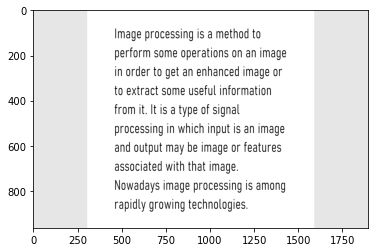

In [74]:
img = cv2.imread('ex1.png')
plt.imshow(img, cmap="gray", aspect="auto")
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
(t,u) = img.shape
plt.imshow(img,cmap="gray",aspect='auto')

# copies of array for further use
copy_1= np.empty_like(img)
copy_1[:,:]=img[:,:]

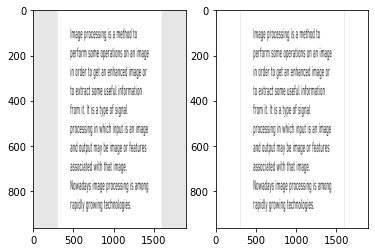

In [75]:
# Adaptive thresholding is best for the project as compared to Otsu or Binary thresholding

Binary_img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
fig,a =  plt.subplots(1,2)
a[0].imshow(img,cmap="gray",aspect='auto')
a[1].imshow(Binary_img,cmap="gray",aspect='auto')

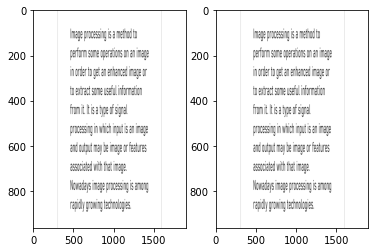

In [76]:
'''
 Noise Removal: The main objective of the Noise removal stage is to smoothen the image by
 removing small dots which have high intensity than the rest of the image.
'''
# Noise removal by using OpenCV medianBlur
def estimate_noise(I):
    H, W = I.shape
    M = [[1, -2, 1],
       [-2, 4, -2],
       [1, -2, 1]]
    sigma = np.sum(np.sum(np.absolute(convolve2d(I, M))))
    sigma = sigma * math_sqrt(0.5 * math_pi) / (6 * (W-2) * (H-2))
    return sigma

w = estimate_noise(Binary_img)

if w>10:
    img1 = cv2.medianBlur(Binary_img,5) 
    img2 = cv2.medianBlur(img1,3) 
    denoise_img = cv2.medianBlur(img2, 1)
else :
    denoise_img = Binary_img

fig,a =  plt.subplots(1,2)
a[0].imshow(Binary_img,cmap="gray",aspect='auto')
a[1].imshow(denoise_img,cmap="gray",aspect='auto')

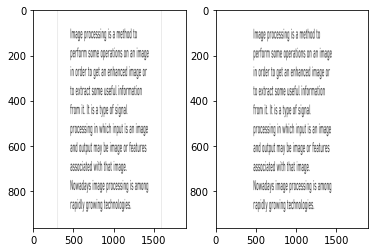

In [77]:
'''
Skeletonization: Different writers have a different style of writing and hence different stroke width.
Hence, have to make width of the strokes uniform.
Here morphological closing operation is performed i.e. image is dilated then eroded.
Thus all the pixels near boundary will be discarded depending upon the size of kernel.
'''
kernel = np.ones((2,2),np.uint8)
img_erode = cv2.dilate(denoise_img,kernel,iterations = 1)
img_dilation = cv2.erode(img_erode,kernel,iterations = 1)

fig, a =  plt.subplots(1,2)
a[0].imshow(denoise_img,cmap="gray",aspect='auto')
a[1].imshow(img_dilation,cmap="gray",aspect='auto')

cpy = np.empty_like(img_dilation)
cpy[:,:]=img_dilation[:,:]
cpy2= np.empty_like(img_dilation)
cpy2[:,:]=img_dilation[:,:]
cpy11= np.empty_like(img_dilation)
cpy11[:,:]=img_dilation[:,:]

C:\Users\III SI\AppData\Local\Temp\ipykernel_1628\2157436046.py:30: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  data = inter.rotate(arr, angle, reshape=False, order=0)
C:\Users\III SI\AppData\Local\Temp\ipykernel_1628\2157436046.py:49: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  skewed_img = inter.rotate(img_dilation,best_angle, reshape=False, order=0)


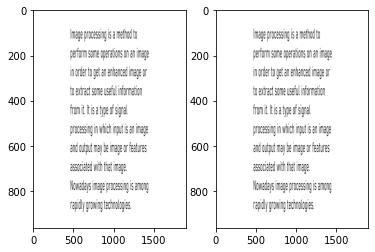

In [78]:
'''
Skew Correction: While scanning a document, it might be slightly skewed (image aligned at a certain
angle with horizontal) ometimes, While extracting the information from the scanned image, detecting
& correcting the skew is crucial. Several techniques skew correction are:
Projection profile method, Hough transformation method, Topline method, Scanline method

 Here Projection profile method is used.
 In this method, 
    i) Taking the sum of black pixels in row wise to get a histogram of pixels along the height of the image.
   ii) Now the image is rotated at various angles  and the variance  will be calculated  The angle at which
       the maximum variance is found, that corresponding angle will be the Skew angle for the image.
  iii) After finding the Skew angle, we can correct the skewness by rotating the image through an angle
      equal to the skew angle in the opposite direction of skew.

'''
fig,a =  plt.subplots(1,2)
a[0].imshow(img_dilation,cmap="gray",aspect='auto')


#applying inversion 
for i in range(t) :
    for j in range(u) :
        if img_dilation[i,j] == 255 :
            img_dilation[i,j] = 0
        else :
            img_dilation[i,j] = 255

# function to find the histogram with rotating the image
def find_variance(arr, angle):
    data = inter.rotate(arr, angle, reshape=False, order=0)
    row_histogram = data.shape[1] - np.sum(data, axis=1)//255
    variance = np.sum((row_histogram[1:] - row_histogram[:-1]) ** 2)
    return row_histogram, variance

#find the angle
delta = 1
limit = 40
angles = np.arange(-limit, limit+delta, delta) #This process fails if we take the angles more than
                                               #60 we might end up getting a upside down img.
variances = []
angles
for angle in angles:
    row_histogram, variance = find_variance(img_dilation, angle)
    variances.append(variance)
best_variance = max(variances)
best_angle = angles[variances.index(best_variance)]

# correct skew
skewed_img = inter.rotate(img_dilation,best_angle, reshape=False, order=0)

#applying inversion 
for i in range(t) :
    for j in range(u) :
        if skewed_img[i,j] == 0 :
            skewed_img[i,j] = 255
        else :
            skewed_img[i,j] = 0

a[1].imshow(skewed_img,cmap="gray",aspect='auto')

#copies of array for further use
cpy14= np.empty_like(skewed_img)
cpy14[:,:]=skewed_img[:,:]
cpy15= np.empty_like(skewed_img)
cpy15[:,:]=skewed_img[:,:]
cpy20= np.empty_like(skewed_img)
cpy20[:,:]=skewed_img[:,:]
cpy21= np.empty_like(skewed_img)
cpy21[:,:]=skewed_img[:,:]

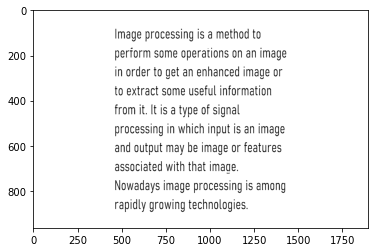

In [79]:
# code for removing the noise between sentences for next algo to work perfectly
horizontal_hist = skewed_img.shape[1] - np.sum(skewed_img,axis=1,keepdims=True)//255
l = sum(horizontal_hist)//len(horizontal_hist)
for i in range(len(horizontal_hist)):
    if horizontal_hist[i]<l//7:
        skewed_img[i,:]=255

plt.imshow(skewed_img,cmap="gray",aspect='auto')

horizontal_hist = []

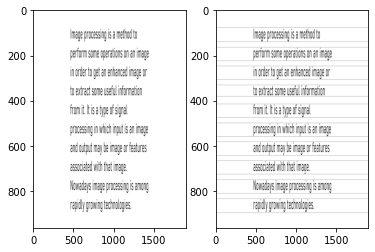

In [80]:
'''
 Line level Segmentation : The idea is, If we Horizontally project the binary image,Rows that represent
the text in a line have high No.of  pixels which correspond to higher peaks in the histogram.
Rows that represent the gaps in-between the lines have high No.of background pixels which correspond to lower
peaks in the histogram.
'''
#function for finding gap between lines
def find_space(arr,i):
    k = 0 
    while arr[i+1+k][0]<3: #l//3
        k=k+1
        if i+1+k == t-1:
            k = 0
            break
    return k

#a histogram to know how many balck pixels are present in a particular row
horizontal_hist = skewed_img.shape[1] - np.sum(skewed_img,axis=1,keepdims=True)//255
l = sum(horizontal_hist)//len(horizontal_hist)
row_no =[]
   
w = find_space(horizontal_hist,0)
row_no.append(95*w//100)

for i in range(t-1) :
  
  if horizontal_hist[i][0]>2:#l
    if horizontal_hist[i+1][0] <3:#l
        x = find_space(horizontal_hist,i)
        havg = 10
        if x > havg :
            row_no.append(i+x*10//100)
            row_no.append(i+x*95//100)    

k = 0
while horizontal_hist[t-1-k][0] < l :
    k = k+1
k = 80*k//100
row_no.append(t-1-k)

for i in row_no :
    skewed_img[i,:] = 100
Line_seg = skewed_img
fig,a =  plt.subplots(1,2)
a[0].imshow(cpy14,cmap="gray",aspect='auto')
a[1].imshow(Line_seg,cmap="gray",aspect='auto')

# copies of array for further use
cpy3 = np.empty_like(Line_seg)
cpy3[:,:]=Line_seg[:,:]

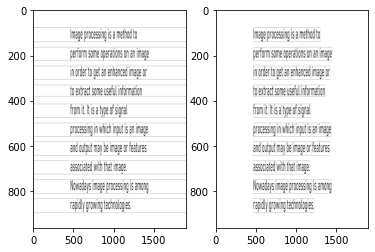

In [81]:
'''
Word level Segmentation : here we need to use  vertical histograms to find the space between the words
in the line segmented image
'''
#code to find gap betwwen words
def find_gap(array,index):
    k = 0 
    while array[0][index+1+k]<2:
        k=k+1
        if index+1+k == u:
            k = 0
            break
    return k

lines = []
final_lines = []
for i in range(len(row_no)) :
    if i%2 == 0 : 
        vertical_hist =  Line_seg[row_no[i]+1:row_no[i+1]-1,:].shape[0] - np.sum(Line_seg[row_no[i]+1:row_no[i+1]-1,:],axis=0,keepdims=True)//255
        lines.append(vertical_hist)


for i in lines :
    ver_lines = []
    y =[]
    x = find_gap(i,0)
    ver_lines.append(99*x//100)

    for j in range (u-1):
        if i[0][j] >1 and  i[0][j+1]<2:
            x = find_gap(i,j)
            y.append(x)
    if max(y)>=2*(sum(y)//len(y)):
        xavg = (max(y)//1.7)
    else:
        xavg = max(y)+10
  
    for j in range (u-1):
        if i[0][j] >1 and  i[0][j+1]<2:    
            x = find_gap(i,j)
            if x>xavg:
                ver_lines.append(j+(3*x//10))
                ver_lines.append(j+(7*x//10))

    k=0
    while i[0][u-1-k] < 2 :
        k = k+1
    k = 99*k//100
    ver_lines.append(u-1-k)
    final_lines.append(ver_lines)
    
final_list = []
for i in range(len(row_no)):
    if i%2 == 0 :
        final_list.append([row_no[i],row_no[i+1],final_lines[i//2]])

array = cpy21
for i in final_list:
    x1 = i[0]
    x2 = i[1]
    y = i[2]
    for i in range(len(y)):
        if i%2 == 0 :
            array[x1,y[i]:y[i+1]] = 100
            array[x2,y[i]:y[i+1]] = 100
            array[x1:x2,y[i]] = 100
            array[x1:x2,y[i+1]] = 100
fig,a =  plt.subplots(1,2)
a[0].imshow(cpy3,cmap="gray",aspect='auto')
a[1].imshow(array,cmap="gray",aspect='auto')

# copies of array for further use
cpy4 = np.empty_like(array)
cpy4[:,:]=array[:,:]

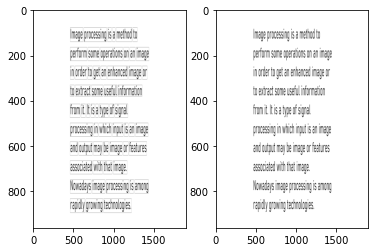

In [82]:
'''
Deslanting :
i) Taking the sum of black pixels in column wise to get a histogram of pixels along the width of the word.
ii) Now the image is sheared at various matrices  and the variance  will be calculated. The angle at which
the maximum variance is found, that corresponding angle will be the shear matrix for the image.
iii) After finding the matrix, we can correct the slant by shearing the image that matrix.
'''

#function to to shear the image 
def find_variance2(arr, x ):
    m = np.array([[1,x,0],[0,1,0]]) 
    rows,col = arr.shape
    k = np.zeros((1000,1000))
    x = (1000-rows)//2
    y = (1000-col)//2
    k[x:x+rows,y:y+col] = arr[:,:]
    rows,col = k.shape
    data = cv2.warpAffine(k, m, (rows,col)) 
    row_histogram = np.sum(data, axis=0)
    variance = np.sum((row_histogram[1:] - row_histogram[:-1]) ** 2)
    return row_histogram, variance

for i in final_list:
    w =i[0]
    z =i[1]
    f =i[2]
    for p in range(len(f)):
        if p%2 == 0 :
            variances = []
            img = array[w+1:z-1,f[p]+1:f[p+1]-1]
            l = z-w-2
            k = f[p+1]-f[p]-2
            for i in range(l) :
                for j in range(k) :
                    if img[i,j] == 255 :
                        img[i,j] = 0
                    else :
                        img[i,j] = 255

            delta = 0.05
            angles = np.arange(-0.9,0.9, delta)
            variances = []

            for angle in angles:
                row_histogram, variance = find_variance2(img,angle)
                variances.append(variance)
            best_variance = max(variances)
            best_angle = angles[variances.index(best_variance)]
            rows,col = img.shape
            m = np.array([[1,best_angle,0],[0,1,0]]) 
            dst = cv2.warpAffine(img, m, (col,rows)) 

            for i in range(l) :
                for j in range(k) :
                    if dst[i,j] == 255 :
                        dst[i,j] = 0
                    else :
                        dst[i,j] = 255
            cpy11[w+1:z-1,f[p]+1:f[p+1]-1] = dst
            cpy14[w+1:z-1,f[p]+1:f[p+1]-1] = dst
fig,a =  plt.subplots(1,2)
a[0].imshow(cpy4,cmap="gray",aspect='auto')
a[1].imshow(cpy14,cmap="gray",aspect='auto')


# copies of array for further use
cpy5 = np.empty_like(array)
cpy5[:,:]=cpy11[:,:]
cpy9 = np.empty_like(cpy14)
cpy9[:,:]=cpy14[:,:]

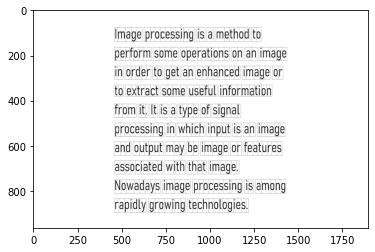

In [83]:
'''
Character level Segmentation : here we need to use vertical histograms to find the minute space between
the characters in the between words
'''
def find_gap(array,index):
    k = 0 
    while array[0][index+1+k]<1:
        k=k+1
        if index+1+k == u:
            k = 0
            break
    return k

def Remove(duplicate):
    final_list = []
    for num in duplicate:
        if num not in final_list:
            final_list.append(num)
    return final_list

lines = []
final_lines = []
for i in range(len(row_no)) :
    if i%2 == 0 : 
        vertical_hist =  cpy11[row_no[i]+1:row_no[i+1]-1,:].shape[0] - np.sum(Line_seg[row_no[i]+1:row_no[i+1]-1,:],axis=0,keepdims=True)//255
        lines.append(vertical_hist)


for i in lines :
    ver_lines = []
    y =[]
  

    for j in range (u-1):
        if i[0][j] >0 and  i[0][j+1]<1:
            x = find_gap(i,j)
            y.append(x)
    xavg = max(y)//2

  
    for j in range (u-1):
        if i[0][j] >0 and  i[0][j+1]<1:    
            x = find_gap(i,j)
            if  x>1:
                ver_lines.append(j+x-2)
        
    final_lines.append(ver_lines)
    
final_list2 = []
for i in range(len(row_no)):
    if i%2 == 0 :
        final_list2.append([row_no[i],row_no[i+1],final_lines[i//2]])

for i in range(len(final_list2)):
    d = final_list[i]
    f = d[2]
    e = final_list2[i]
    v = e[2]
    w = []
    for j  in range(len(f)):
        if j%2 == 0:
            w = []
            for l in range(len(v)):
                if v[l]>f[j]+7 and v[l]<f[j+1]:
                    w.append(v[l])
            w.append(f[j])    
            w.append(f[j+1]) 
            w.sort()
            p = Remove(w)
            d.append(p)


array2 = cpy14
for i in final_list:
    x1 = i[0]
    x2 = i[1]
    z = i[2]
    for f in range(len(z)):
        if f%2 == 0 :
            array2[x1,z[f]:z[f+1]] = 100
            array2[x2,z[f]:z[f+1]] = 100


    for o in range(3,len(i)):
        y = i[o]
        for k in range(len(y)):
            array2[x1:x2,y[k]] = 100

plt.imshow(array2,cmap="gray",aspect='auto')

In [84]:
'''
Feature Extraction: there are 3 feature techniques
                    i)  Statistical
                    ii)  Structural
                    iii)  Global transformations and moments
 we extract different features like Zoning, Projections and profiles,Crossings and distances,
 then make each feature as a vector for particular letter, then use classifier to predict the
 inputs. Here we are going to use svm classifier which does all the above for us.but as our
 processors are that fast and svm is too slow , we used a neural network model.               
'''

mapp = pd.read_csv('emnist_mappings.txt', delimiter=' ', names=['ASCII'])
mapp.head()
string_list = [chr(i) for i in mapp['ASCII'].values]
mapp['String'] = string_list
model = load_model('emnist_model_byclass.h5')

#resizing function
def get_square(image, square_size):
    height, width = image.shape    
    if(height > width):
        differ = height
    else:
        differ = width
    differ += 4
    
    # square filler
    mask = np.zeros((differ, differ), dtype = "uint8")

    x_pos = int((differ - width) / 2)
    y_pos = int((differ - height) / 2)

    # center image inside the square
    mask[y_pos: y_pos + height, x_pos: x_pos + width] = image[0: height, 0: width]

    # downscale if needed
    if differ / square_size > 1:
        mask = pyramid_reduce(mask, differ / square_size)
        if mask.shape != (28,28):
            mask = cv2.resize(mask, (square_size, square_size), interpolation = cv2.INTER_AREA)
    else:
        mask = cv2.resize(mask, (square_size, square_size), interpolation = cv2.INTER_AREA)
    return mask

def convert(s):
    new = ""
    for x in s:
        new += x 
    return new

for i in range(t) :
    for j in range(u) :
        if cpy5[i,j] == 0 :
            cpy5[i,j] = 255
        else :
            cpy5[i,j] = 0

final_Img = cpy5
sentance_list = []
for i in final_list:
    x1 = i[0]
    x2 = i[1]
    l = len(i)
    word_list = []
    for w in range(3,len(i)):
        z = i[w]
        char_list = []
        for f in range(len(z)-1):
            image = final_Img[x1:x2,z[f]:z[f+1]]
            image_2 = get_square(image,28)
            newer_image = image_2.reshape(1, 28, 28, 1)        
            pred = np.argmax(model.predict(newer_image), axis=1)
            f = mapp['String'][pred]
            k = f.tolist()
            q = k[0]
            char_list.append(q)
        word_list.append(convert(char_list))
    sentance_list.append(word_list)

def text(p):
    last = ""
    for i in p :
        new = ""
        for j in i :
            new = new + ' ' + j
        last =  last +'\n' + new
    return last
final_text = text(sentance_list)
final_text = final_text +'\n'
print(final_text) 


 lMage pr0CeSSing iS a Meth0d I0
 per10rM S0Me 0perati0nS 0n an iMage
 in 0rder t0 0et an ennanCed iMage 0r
 t0 extraCt S0Me USeFU1 jnF0rMatj0n
 1r0M it1 1t iS a Iype 0I Signa1
 pr0CeSSing in wniCn inpUt iS an iMage
 an0 0UtpUt May be iMage 0r 1eatUreS
 aSS0Ciated with Ihat iMage1
 N0wa0ayS iMage pr0CeSSing iS aM0ng
 rapidly gr0wing IeCnn0l0gieS1



In [86]:
'''
Postprocessing: here we will be doing spell correction using textblob and spell correction and
finally create the document consisting the text.
'''
s = final_text
p = []
q = []

for k in s :
    p.append(k)
    if k == '\n':
        q.append(convert(p))
        p = []
j =[]
w = 0
for i in q:
    spell = sc()
    list1 = list(i.split())
    k=[]
    for word in list1:
        b = spell.correction(word)
        temp = b
        if(w==0):
            b = b[0].upper()+b[1:].lower()
        else:
            b = b[0].lower()+b[1:].lower()
        k.append(b)
        w = w+1
    j.append(k) 
    
final_text2 = text(j)
para1 = TextBlob(final_text2)           
para2 = str(para1.correct())       
mydoc = docx.Document()
mydoc.add_paragraph(para2)
mydoc.save("processed.docx")
doc = docx.Document("processed.docx")
all_paras = doc.paragraphs
for para in all_paras:
    print(para.text)



 Image processing is a method i
 perform some operations in an image
 in order to get an enhanced image or
 to extract some useful jnf0rmatj0n
 from it it is a type i signal
 processing in which input is an image
 and output may be image or features
 associated with that image
 nowadays image processing is among
 rapidly growing iecnn0l0gies1
